# Trabajo Práctico 3: Como perros y gatos

## Análisis de datos

Contamos con un total de 8000 imagenes de perros y gatos para el dataset de entrenamiento y 2000 imagenes para el dataset de test/validation.

In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image, display
from PIL import Image as PILImage
import os, os.path
from collections import Counter

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

CLASSES = "cats", "dogs"
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set')

Realizamos un análisis de los datos y detectamos la resolución más frecuente

In [2]:
imgs = []
images_amount = {}

valid_images = [".jpg"]
for CLASS in CLASSES:
    images_amount[CLASS] = 0
    path = './imagenes_tp3_cv/training_set/'+CLASS
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(Image.open(os.path.join(path,f)))
        images_amount[CLASS] += 1
        
counter = dict(Counter(getattr(image, 'size') for image in imgs))
c = max(counter, key = lambda x: x[1])
print("Resolución mas frecuente: ", c)

width=100 #c[0]
height=100 #c[1]

Resolución mas frecuente:  (1023, 768)


In [2]:
width=100 #c[0]
height=100 #c[1]

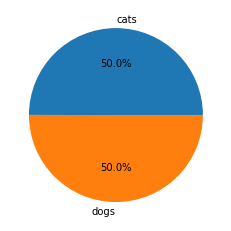

{'cats': 4000, 'dogs': 4005}

In [4]:
plt.pie([float(images_amount[v]) for v in images_amount], labels=[str(k) for k in images_amount], autopct='%1.1f%%')
plt.show()
images_amount

#### Tamaño de imagenes
La distribucion en los tamaños de las imagenes es demasiado amplia y por eso optamos por una resolucion de 64x64 priorizando la velocidad en el entrenamiento de los modelos ya que observamos resultados satisfactorios.

## Modelos

In [80]:
def print_predictions_table (model, train_set, test_set):
    datasets = (
        ("train", train_set),
        ("test", test_set),   
    )
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], CLASSES, rotation=45)
        plt.yticks([0, 1], CLASSES)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

# MLP Convulsional

In [68]:
train_cvl = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

test_cvl = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


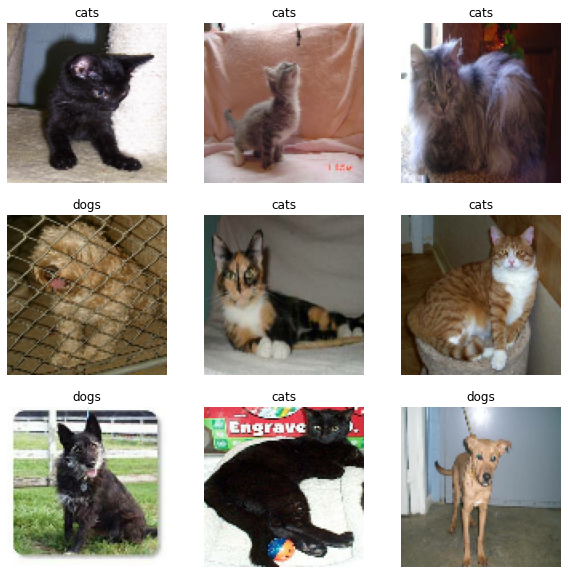

In [6]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASSES[np.argmax(labels[i])])
            plt.axis("off")
sample_images(train_cvl)

In [69]:
model_cvl = Sequential([
    Rescaling(1/255, input_shape=(width, height, 3)),
    
    Convolution2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),    
    
    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    
    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),    
    
    Flatten(), 
    
    Dense(512, activation='tanh'),
    Dropout(0.2),   
    
    Dense(len(CLASSES), activation='softmax'),
])

model_cvl.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [70]:
history_cvl = model_cvl.fit(
    train_cvl,
    epochs=20,
    batch_size=128,
    validation_data=test_cvl,
)

Epoch 1/20
251/251 [==============================] - 36s 135ms/step - loss: 0.7423 - accuracy: 0.5412 - val_loss: 0.6913 - val_accuracy: 0.6026
Epoch 2/20
251/251 [==============================] - 34s 135ms/step - loss: 0.6220 - accuracy: 0.6653 - val_loss: 0.7195 - val_accuracy: 0.5838
Epoch 3/20
251/251 [==============================] - 35s 137ms/step - loss: 0.5563 - accuracy: 0.7149 - val_loss: 0.5237 - val_accuracy: 0.7331
Epoch 4/20
251/251 [==============================] - 34s 136ms/step - loss: 0.5240 - accuracy: 0.7385 - val_loss: 0.5009 - val_accuracy: 0.7632
Epoch 5/20
251/251 [==============================] - 34s 135ms/step - loss: 0.4904 - accuracy: 0.7663 - val_loss: 0.5254 - val_accuracy: 0.7375
Epoch 6/20
251/251 [==============================] - 35s 137ms/step - loss: 0.4845 - accuracy: 0.7735 - val_loss: 0.5356 - val_accuracy: 0.7420
Epoch 7/20
251/251 [==============================] - 35s 138ms/step - loss: 0.4548 - accuracy: 0.7858 - val_loss: 0.4514 - val_ac

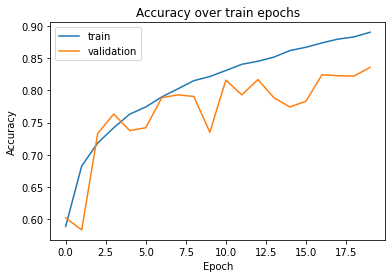

In [71]:
plt.plot(history_cvl.history['accuracy'], label='train')
plt.plot(history_cvl.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

######################### train #########################
accuracy 0.9345409119300437


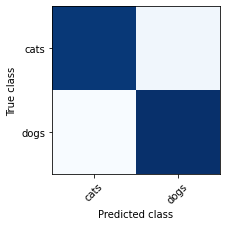

######################### test #########################
accuracy 0.8353929807217004


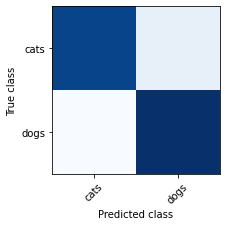

In [81]:
print_predictions_table(model_cvl, train_cvl, test_cvl)

## Predicciones

In [61]:
def predict(image_path, model, color_mode):
    image_array = img_to_array(load_img(image_path, target_size=(100, 100, 1), color_mode = color_mode))
    inputs = np.array([image_array])  
    predictions = model.predict(inputs)
    display(Image(image_path, width=200))
    print("Prediction:", CLASSES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

### Gatos

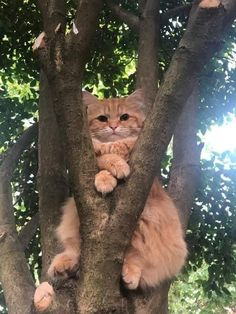

Prediction: cats
Prediction detail: [[0.8293795  0.17062053]]


In [72]:
predict('./ejemplos/gato_arbol.jpg', model_cvl, "rgb")

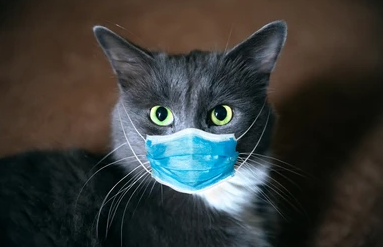

Prediction: cats
Prediction detail: [[0.98609537 0.01390459]]


In [73]:
predict('./ejemplos/gato_barbijo.png', model_cvl, "rgb")

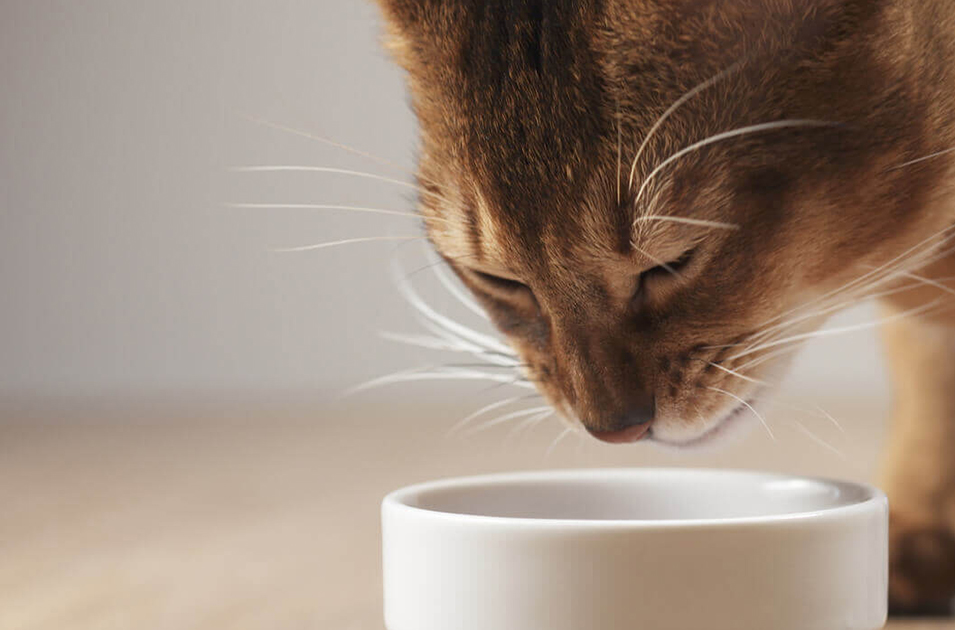

Prediction: cats
Prediction detail: [[0.9808039  0.01919609]]


In [74]:
predict('./ejemplos/gato_tarro.jpeg', model_cvl, "rgb")

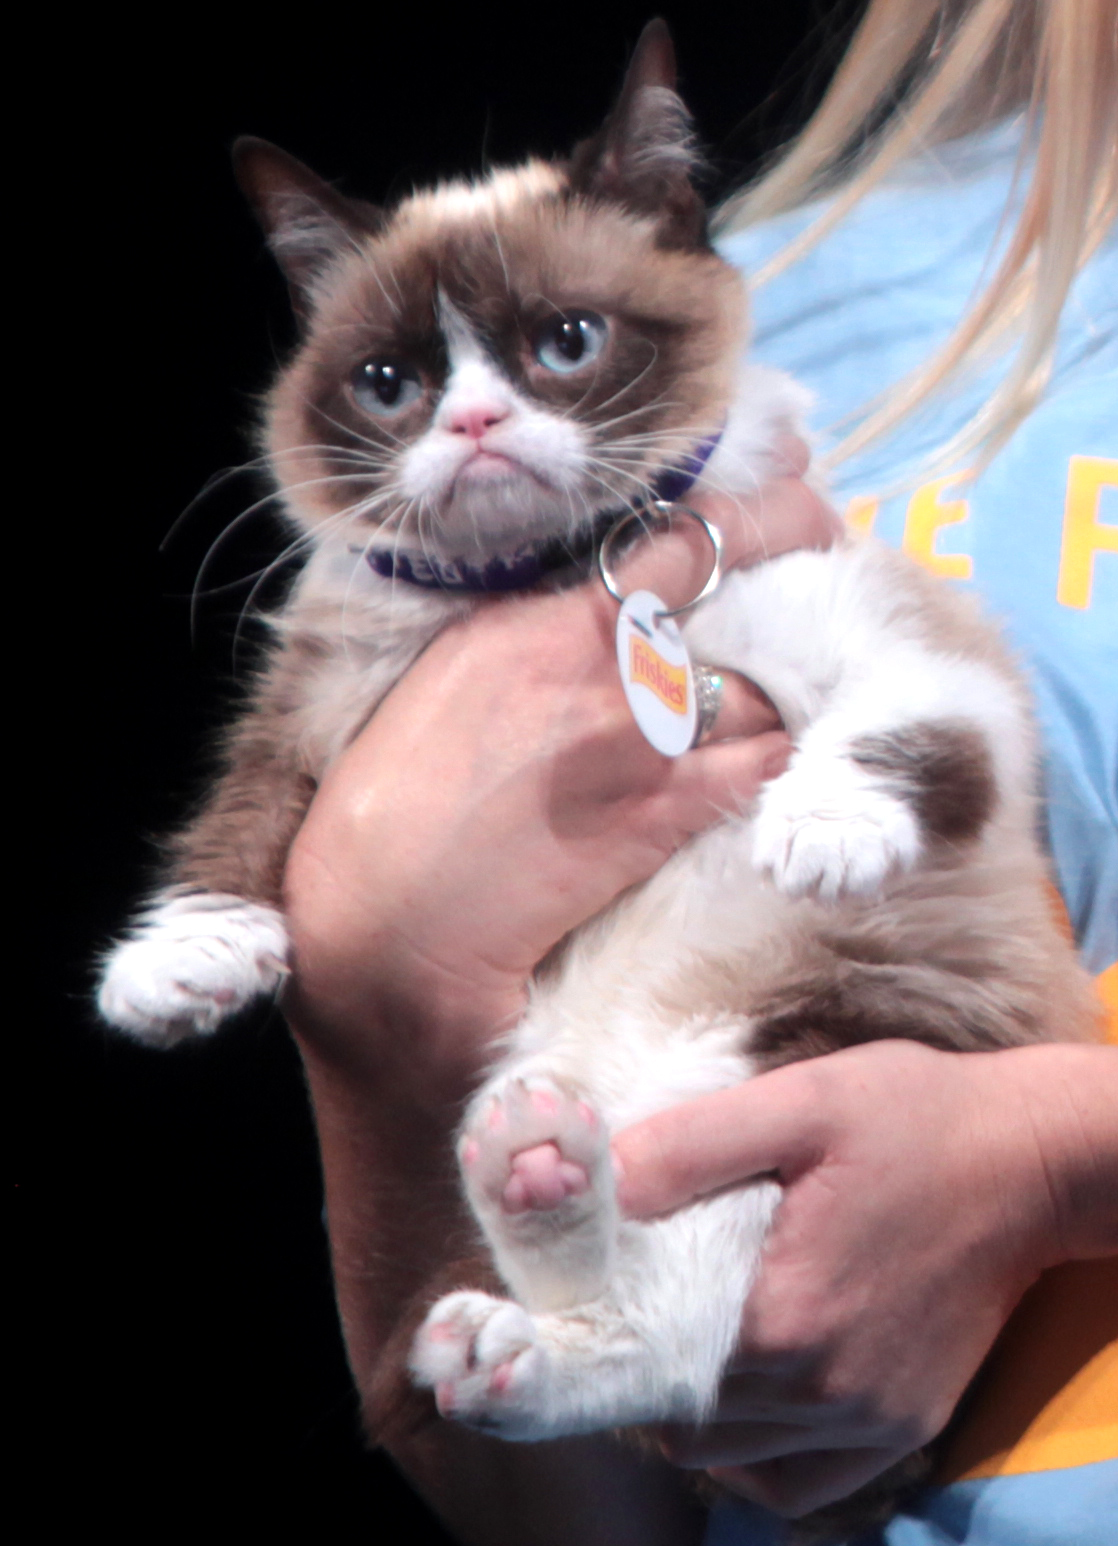

Prediction: dogs
Prediction detail: [[0.47336328 0.5266367 ]]


In [75]:
predict('./ejemplos/gato_enojado.jpg', model_cvl, "rgb")

### Perros

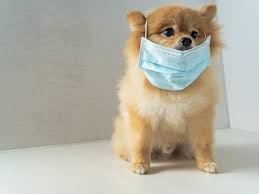

Prediction: cats
Prediction detail: [[0.9501038 0.0498962]]


In [76]:
predict('./ejemplos/perro_barbijo.jpg', model_cvl, "rgb")

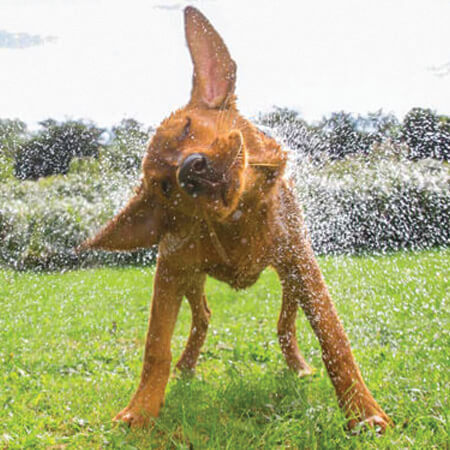

Prediction: dogs
Prediction detail: [[0.03976304 0.96023697]]


In [77]:
predict('./ejemplos/perro_sacudida.jpg', model_cvl, "rgb")

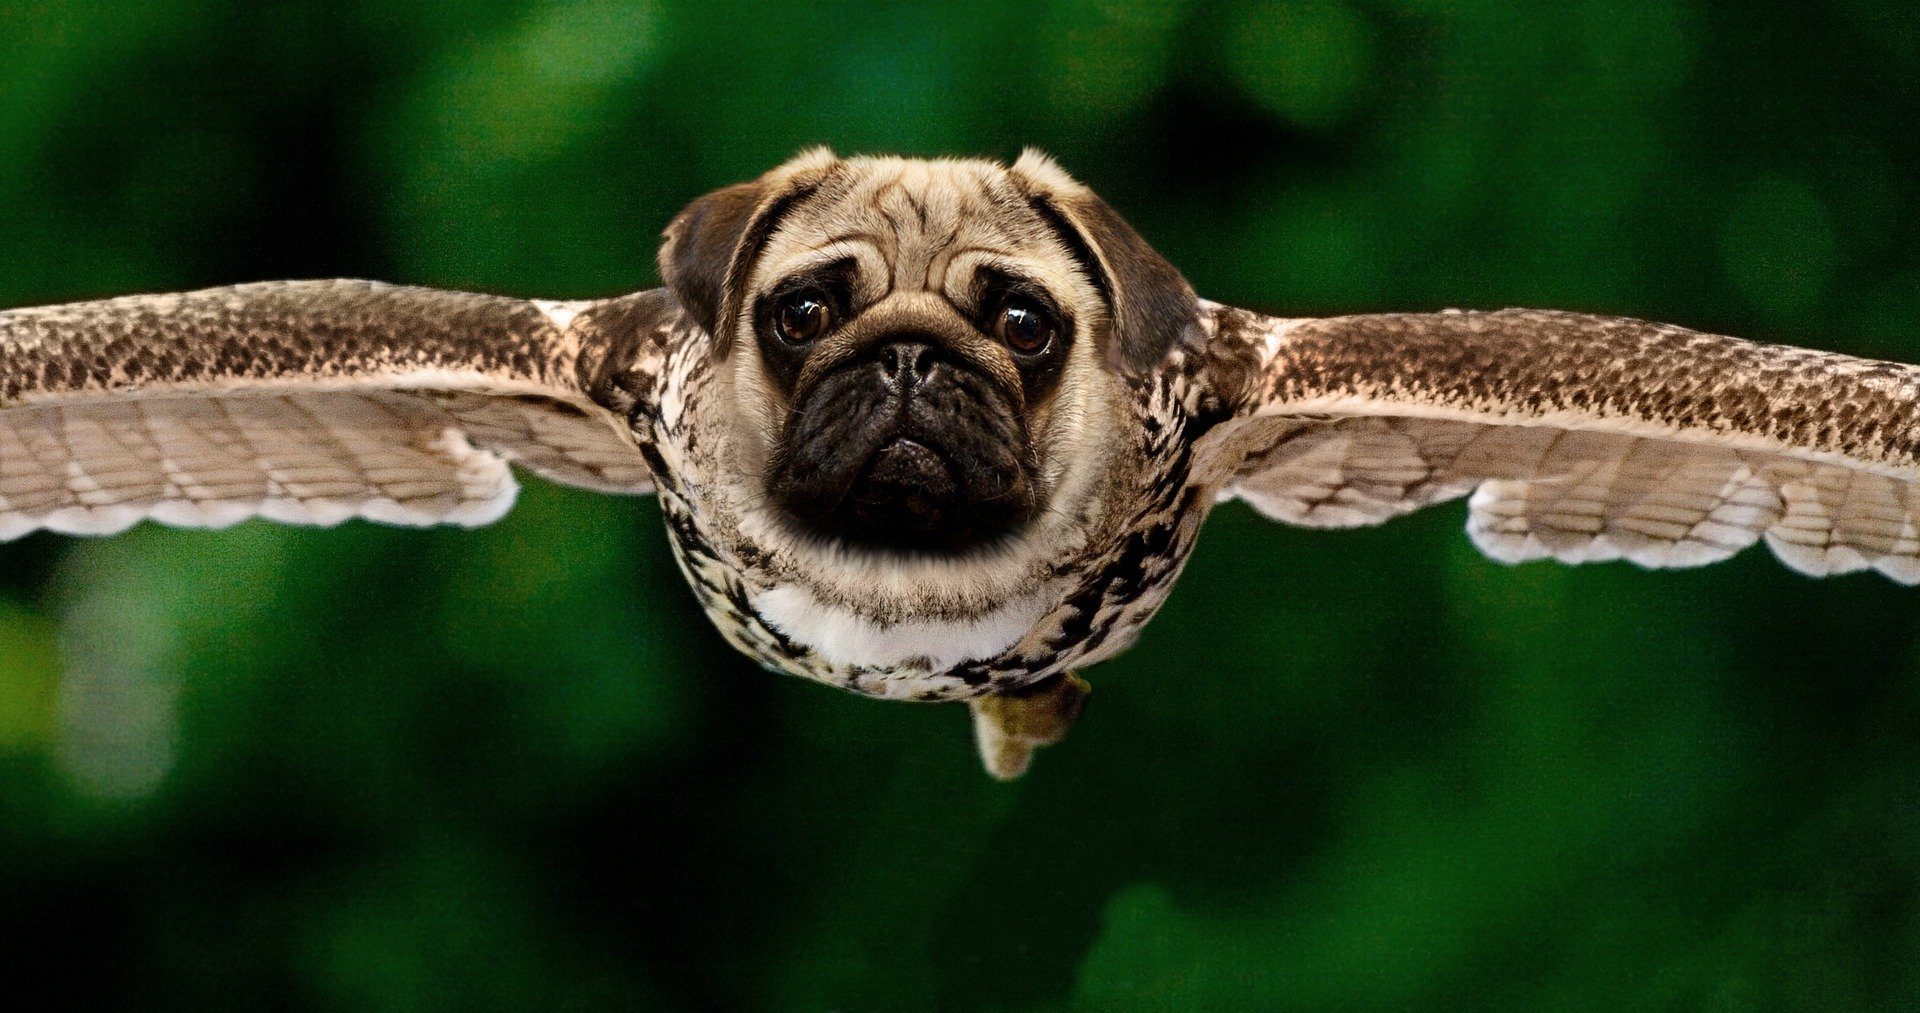

Prediction: dogs
Prediction detail: [[0.00237624 0.99762374]]


In [78]:
predict('./ejemplos/perro_volador.jpg', model_cvl, "rgb")

# MLP Simple

In [3]:
train_simple = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

test_simple = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [57]:
model_simple = Sequential([
    Rescaling(1/255, input_shape=(width, height, 3)),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Flatten(),
    
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    
    Dense(len(CLASSES), activation='softmax'),
])

model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [58]:
history_simple = model_simple.fit(
    train_simple,
    epochs=10,
    batch_size=64,
    validation_data=test_simple,
)

Epoch 1/10
251/251 [==============================] - 291s 1s/step - loss: 3.5808 - accuracy: 0.5130 - val_loss: 0.6748 - val_accuracy: 0.5714
Epoch 2/10
251/251 [==============================] - 270s 1s/step - loss: 0.6823 - accuracy: 0.5613 - val_loss: 0.6662 - val_accuracy: 0.6016
Epoch 3/10
251/251 [==============================] - 265s 1s/step - loss: 0.6557 - accuracy: 0.6157 - val_loss: 0.6393 - val_accuracy: 0.6396
Epoch 4/10
251/251 [==============================] - 262s 1s/step - loss: 0.6247 - accuracy: 0.6480 - val_loss: 0.6427 - val_accuracy: 0.6698
Epoch 5/10
251/251 [==============================] - 262s 1s/step - loss: 0.6038 - accuracy: 0.6724 - val_loss: 0.6093 - val_accuracy: 0.6846
Epoch 6/10
251/251 [==============================] - 260s 1s/step - loss: 0.5865 - accuracy: 0.6959 - val_loss: 0.5918 - val_accuracy: 0.6940
Epoch 7/10
251/251 [==============================] - 261s 1s/step - loss: 0.5461 - accuracy: 0.7220 - val_loss: 0.5973 - val_accuracy: 0.7014

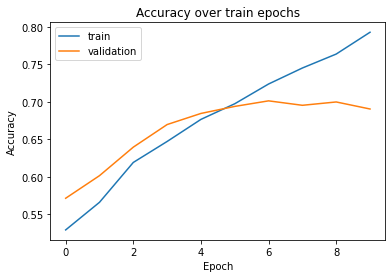

In [59]:
plt.plot(history_simple.history['accuracy'], label='train')
plt.plot(history_simple.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

######################### train #########################
accuracy 0.8443472829481574


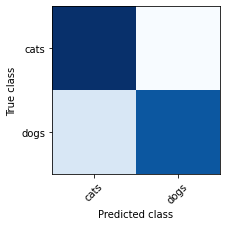

######################### test #########################
accuracy 0.6905585763717251


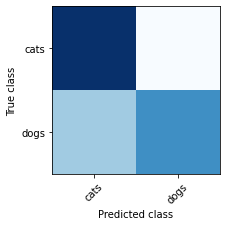

In [82]:
print_predictions_table(model_simple, train_simple, test_simple)

## Predicciones

### Gatos

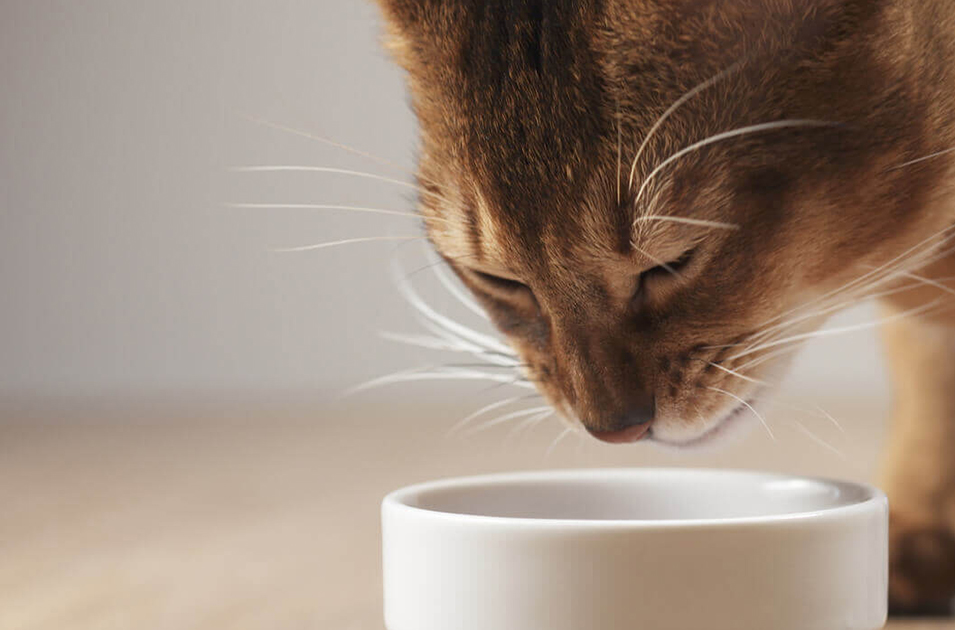

Prediction: cats
Prediction detail: [[0.7979839  0.20201613]]


In [63]:
predict('./ejemplos/gato_tarro.jpeg', model_simple, "rgb")

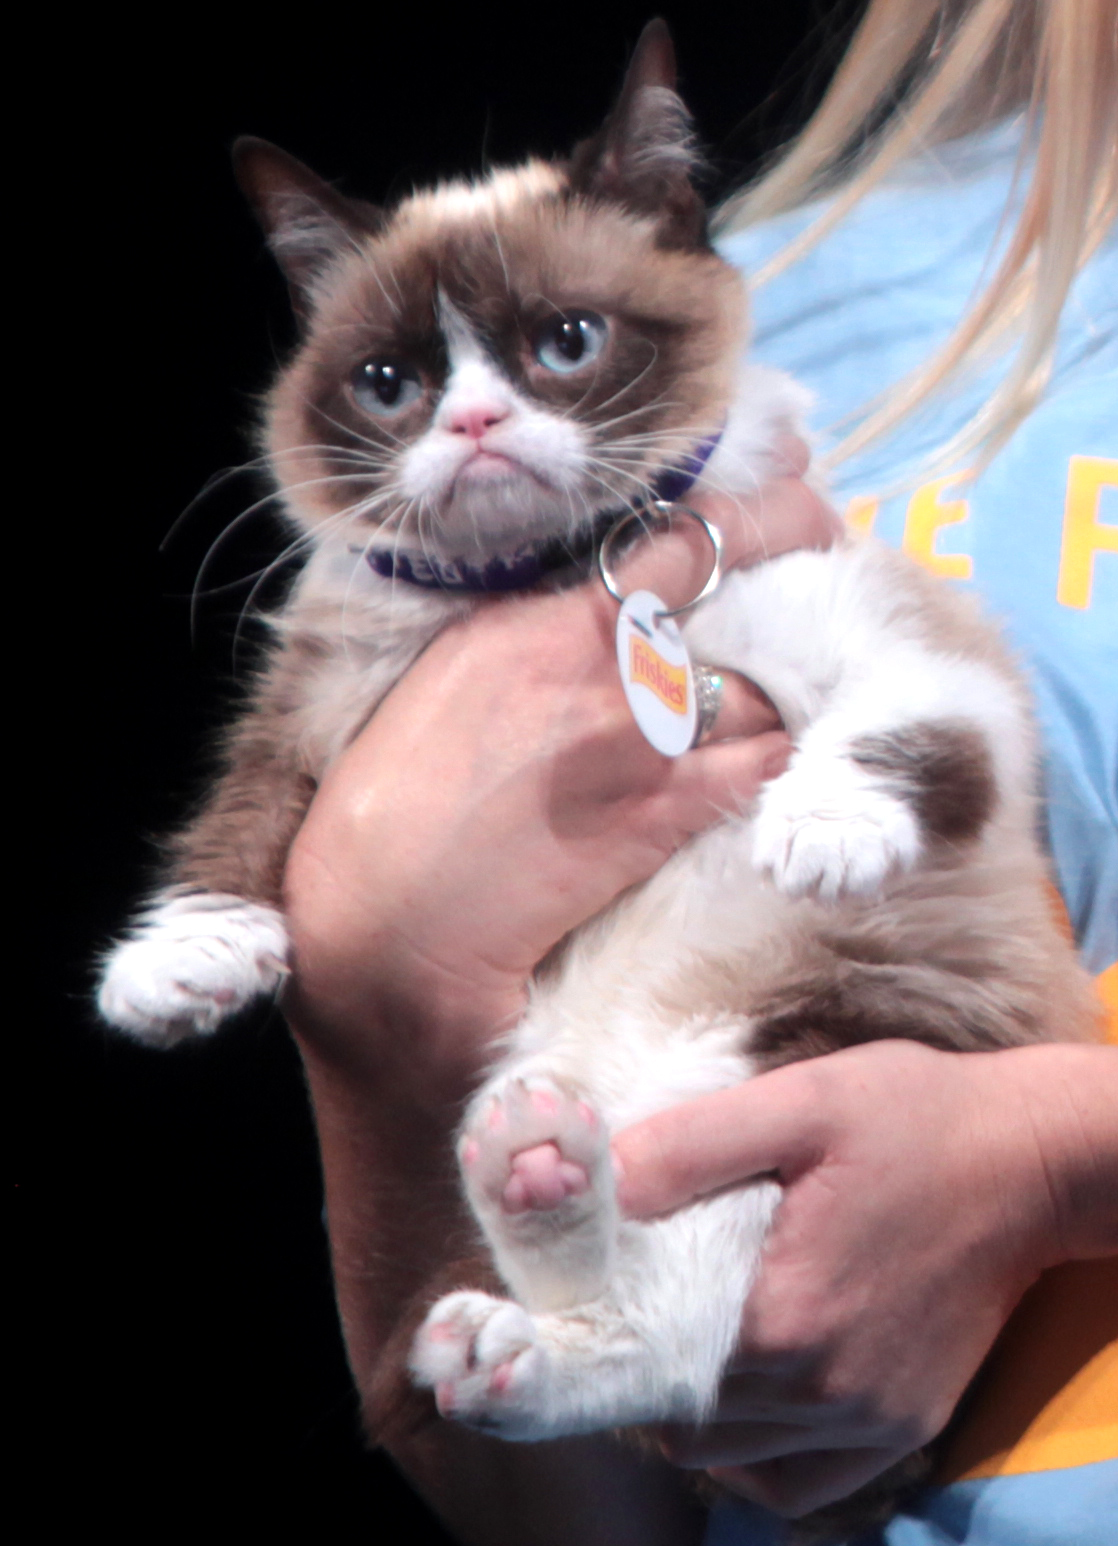

Prediction: cats
Prediction detail: [[0.8731195  0.12688048]]


In [64]:
predict('./ejemplos/gato_enojado.jpg', model_simple, "rgb")

### Perros

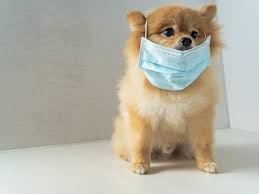

Prediction: cats
Prediction detail: [[0.83834285 0.16165715]]


In [65]:
predict('./ejemplos/perro_barbijo.jpg', model_simple, "rgb")

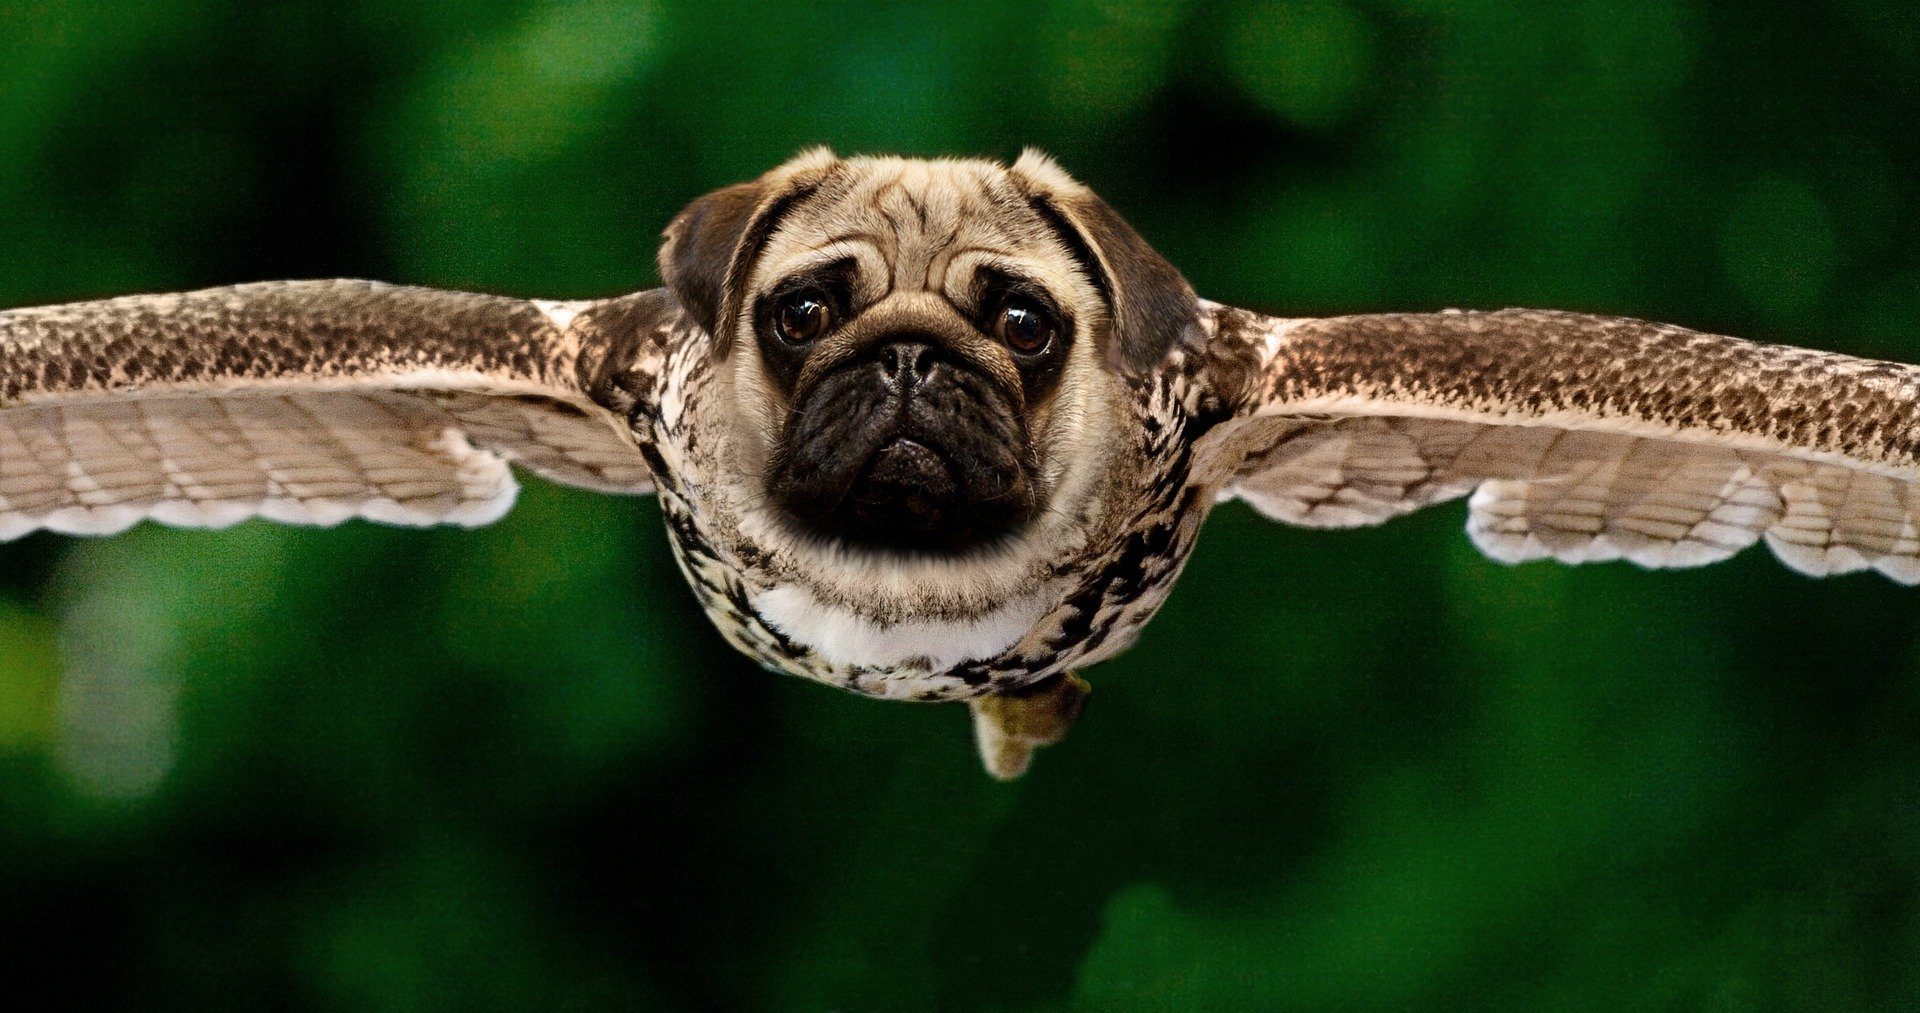

Prediction: dogs
Prediction detail: [[0.00169981 0.99830025]]


In [66]:
predict('./ejemplos/perro_volador.jpg', model_simple, "rgb")

# Conclusión:
Ambos modelos llegan a un porcentaje de aciertos bastante eleveado ≈70% en MLP y ≈85 en CNN usando la misma cantidad de epocas (20).
En el caso de CNN podemos ver en la grafica de evolucion como el accuracy de test no evoluciona de forma constante y suave al igual que train, sino que dependiendo la epoca tendra mayor o menor valor generando picos maximos y minimos, pero siempre tendiendo a subir.
Para el caso de MLP en cambio, ambas grafricas evolucionan constante y suave pero en el caso de el conjunto de test vemos con mayor claridad como se va achatando cada vez al punto de comenzar a descender a causa de un sobreentrenamiento.

Por el lado de las matrices de confusion, el modelo CNN presenta mayor cantidad de falsos positivos para la clase **dogs** tanto en el set de test como en el de train.
En el caso de MLP, presenta mayores falsos positivos de la categoria **cats** tanto en el set de train como test. Pero para ambos sets de datos el porcentaje de aciertos con gatos


### Mejoras
Como posibles mejoras a desarrollar en un futuro para mejorar el rendimiento del modelo pensamos:
Utilizar un set de datos más grande o generarlo a partir de GANs.
Aumentar el dataset con técnicas como girar, espejar y/o mover las imágenes.
Realizar pruebas con mayores dimensiones en las imágenes para comprobar si se obtienen mejores resultados o modificar las configuraciones de las capasa de los modelos.